In [1]:
from sqlalchemy import create_engine, inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, time, datetime
import pymysql

#Datos de conexión
usuario='EquipoB'
contraseña="E1q2u3i4p5oB"
host='212.227.90.6'
puerto=3306
nombre_base_datos='EquipB'

#URL de la conexión
url_conexion=f"mysql+pymysql://{usuario}:{contraseña}@{host}:{puerto}/{nombre_base_datos}"

#Crear l'engine de SQLAlchemy
try:
    engine=create_engine(url_conexion)
    cnx=engine.connect()
    print("Conexión correcta")
except Exception as e:
    print(f"Error al conectar con SQLAlchemy: {e}")
    
#Obtener el nombre de les tablas
inspector=inspect(engine)
nombre_tablas=inspector.get_table_names()

# Diccionario para almacenar los DataFrames
df= {}

for tabla in nombre_tablas:
    query=f"SELECT * FROM {tabla}"
    
    try:
        df[tabla] = pd.read_sql(query, cnx)
        print(f"Tabla '{tabla}' cargada correctamente.")
    except Exception as e:
        print(f"Error al cargar la tabla '{tabla}':{e}")
  
# Cerrrar la conexión
cnx.close()

Conexión correcta
Tabla 'BANK_marketing' cargada correctamente.
Tabla 'BANK_marketing131024' cargada correctamente.


In [2]:
df_bank = df['BANK_marketing131024']

df_bank

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,1,59,admin.,married,secondary,0,2343,1,0,unknown,5,may,1042,1,-1,0,unknown,1
1,2,59,admin.,married,secondary,0,2343,1,0,unknown,5,may,1042,1,-1,0,unknown,1
2,3,56,admin.,married,secondary,0,45,0,0,unknown,5,may,1467,1,-1,0,unknown,1
3,4,41,technician,married,secondary,0,1270,1,0,unknown,5,may,1389,1,-1,0,unknown,1
4,5,55,services,married,secondary,0,2476,1,0,unknown,5,may,579,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16158,21379,26,admin.,married,secondary,0,1595,0,0,cellular,15,jun,155,1,105,1,failure,1
16159,21380,37,admin.,married,secondary,0,1967,0,0,cellular,27,may,242,1,212,1,success,1
16160,21381,45,management,married,tertiary,0,81,0,1,cellular,30,jul,61,3,-1,0,unknown,0
16161,21382,44,services,single,secondary,0,618,0,0,cellular,12,may,193,1,-1,0,unknown,1


In [3]:
#vista de las columnas relevantes para el análisis financiero
df_finanzas = df_bank[['id','age','job','marital','education','default','balance','housing','loan']]

In [4]:
df_finanzas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16163 entries, 0 to 16162
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         16163 non-null  int64 
 1   age        16163 non-null  int64 
 2   job        16163 non-null  object
 3   marital    16163 non-null  object
 4   education  16163 non-null  object
 5   default    16163 non-null  int64 
 6   balance    16163 non-null  int64 
 7   housing    16163 non-null  int64 
 8   loan       16163 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.1+ MB


In [5]:
df_finanzas.isnull().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
dtype: int64

In [6]:
#defino estilo para los gráficos 
plt.style.use("seaborn-v0_8-deep")

#colores de este estilo:
#4C72B0 – Azul
#55A868 – Verde
#C44E52 – Rojo
#8172B3 – Púrpura
#CCB974 – Amarillo mostaza
#64B5CD – Cian/Azul claro

### Varible "housing"

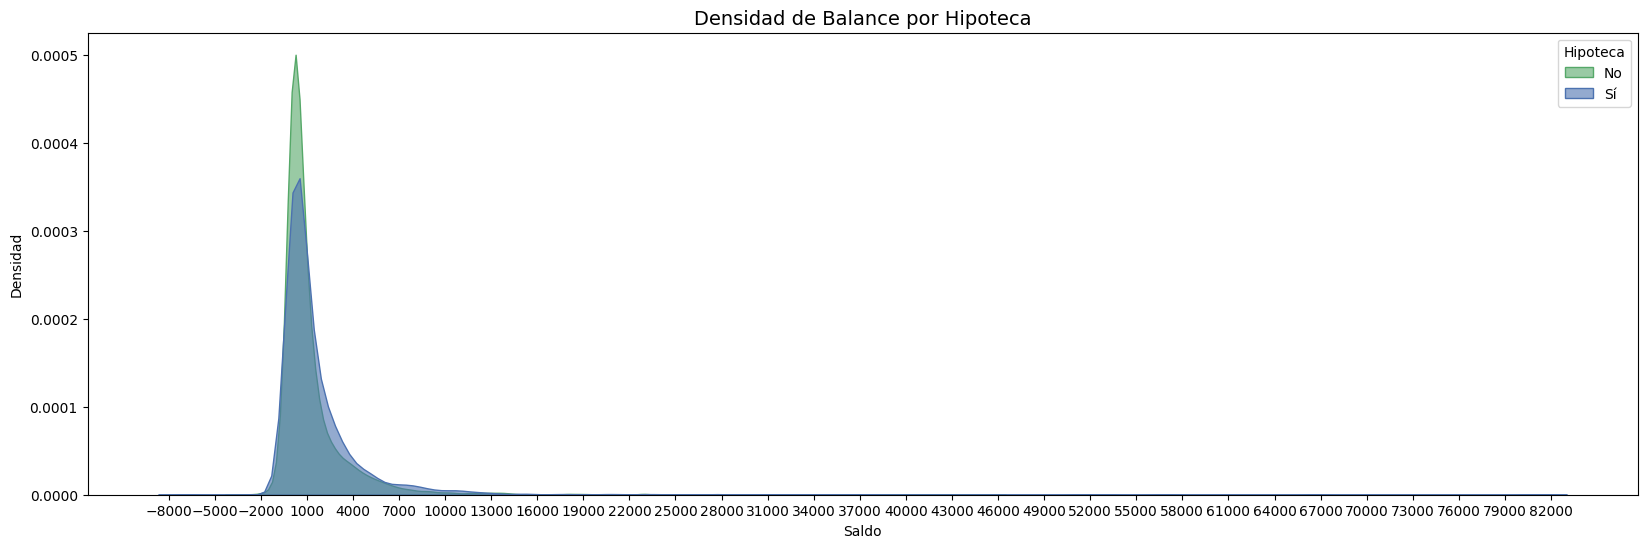

In [7]:
plt.figure(figsize=(20, 6))

sns.kdeplot(data=df_finanzas, x='balance', hue='housing', hue_order=[0, 1], fill=True, common_norm=False, alpha=0.6)

plt.title('Densidad de Balance por Hipoteca', fontsize=14)
plt.legend(title="Hipoteca", labels=["No","Sí"])
plt.xlabel('Saldo')
plt.ylabel('Densidad')

plt.xticks(range(-8000,85000,3000))

plt.show()

### Categorización 

Definimos 4 categorías para clasificar los clientes (nombres provisionales): 
* **"Con Préstamo, Con Hipoteca"**: Sí hipoteca (Housing), Sí préstamo (Loan)
* **Con Hipoteca**: Sí hipoteca, No préstamo
* **Con Préstamo**: No hipoteca, Sí préstamo
* **Sin Préstamo, Sin Hipoteca**: No hipoteca, No préstamo

In [8]:
def clasificacion_clientes (housing, loan):
    if housing == 1 and loan == 1:
        return "CON Préstamo, CON Hipoteca"
    elif housing == 1 and loan == 0:
        return "CON Hipoteca"
    elif housing == 0 and loan == 1:
        return "CON Préstamo"
    elif housing == 0 and loan == 0:
        return "SIN Préstamo, SIN Hipoteca"
    else:
        return "No categorizado" # no deberíamos tener clientes en esta categoria
    
    
# para clasificar a los clientes segun los dos parametros utilizados en la funcion: 
# df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)

df_finanzas["categoria_cliente"] = df_finanzas.apply(lambda x: clasificacion_clientes(x.housing, x.loan), axis=1)

# ordeno las categorias para que aparezcan siempre en el mismo orden en los gráficos
orden_categorias = ['SIN Préstamo, SIN Hipoteca', 'CON Préstamo', 'CON Hipoteca', 'CON Préstamo, CON Hipoteca']

df_finanzas["categoria_cliente"] = pd.Categorical(df_finanzas["categoria_cliente"],
                                                  categories=orden_categorias,
                                                  ordered=True)

C:\Users\Natalya\AppData\Local\Temp\ipykernel_9528\1700769271.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finanzas["categoria_cliente"] = df_finanzas.apply(lambda x: clasificacion_clientes(x.housing, x.loan), axis=1)
C:\Users\Natalya\AppData\Local\Temp\ipykernel_9528\1700769271.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finanzas["categoria_cliente"] = pd.Categorical(df_finanzas["categoria_cliente"],


In [9]:
df_finanzas

,id,age,job,marital,education,default,balance,housing,loan,categoria_cliente
0,1,59,admin.,married,secondary,0,2343,1,0,CON Hipoteca
1,2,59,admin.,married,secondary,0,2343,1,0,CON Hipoteca
2,3,56,admin.,married,secondary,0,45,0,0,"SIN Préstamo, SIN Hipoteca"
3,4,41,technician,married,secondary,0,1270,1,0,CON Hipoteca
4,5,55,services,married,secondary,0,2476,1,0,CON Hipoteca
...,...,...,...,...,...,...,...,...,...,...
16158,21379,26,admin.,married,secondary,0,1595,0,0,"SIN Préstamo, SIN Hipoteca"
16159,21380,37,admin.,married,secondary,0,1967,0,0,"SIN Préstamo, SIN Hipoteca"
16160,21381,45,management,married,tertiary,0,81,0,1,CON Préstamo
16161,21382,44,services,single,secondary,0,618,0,0,"SIN Préstamo, SIN Hipoteca"


In [10]:
#defino colores para destacar la categoría "control" que corresponde a los clientes sin préstamo ni hipoteca 
colores = ["#55A868","#4C72B0","#4C72B0","#4C72B0"]

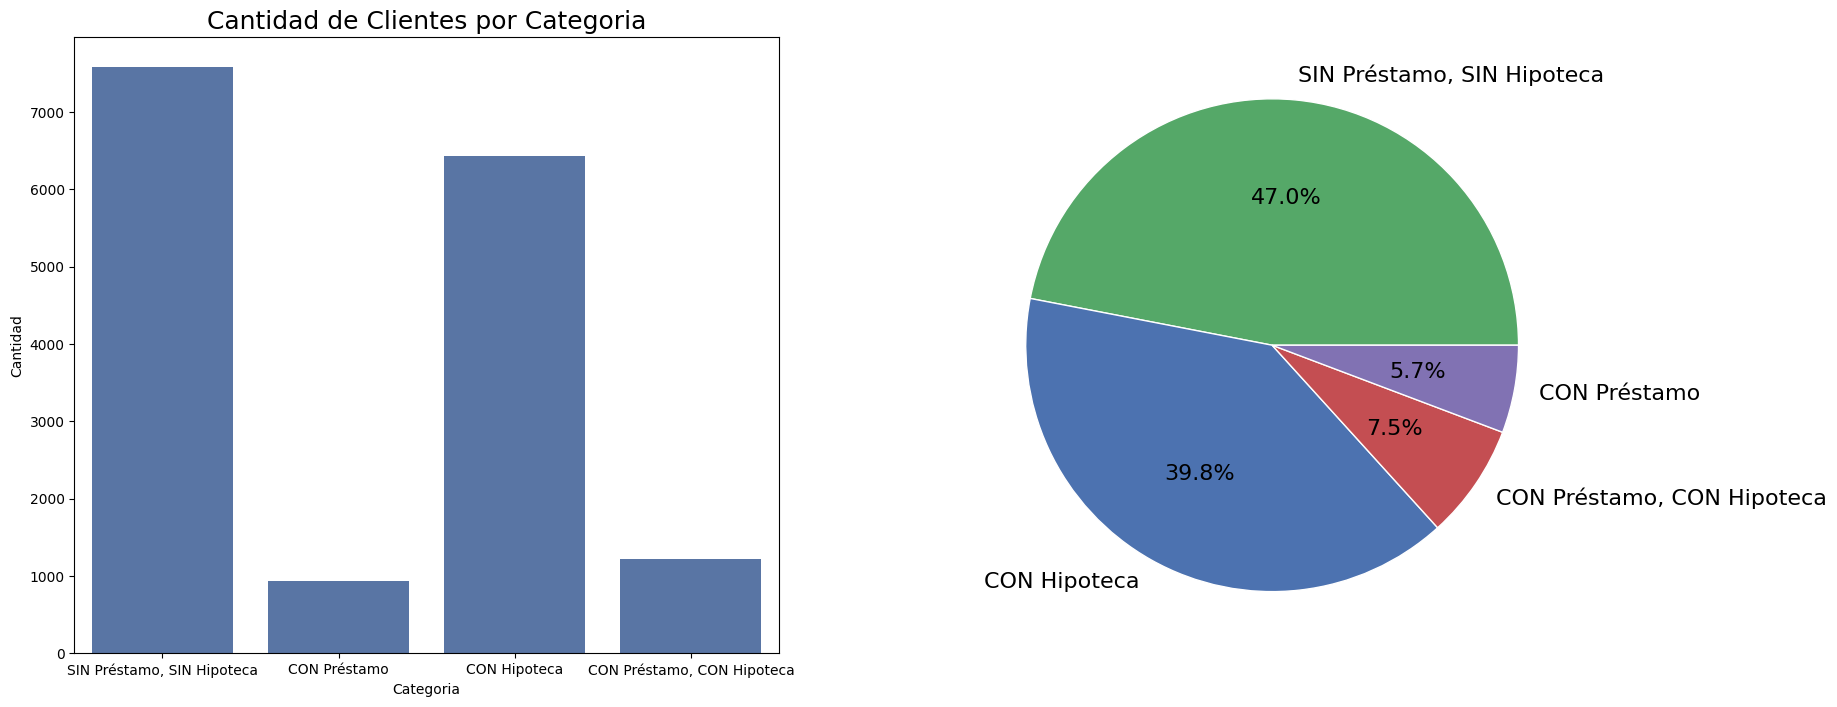

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.countplot(data=df_finanzas,
              x="categoria_cliente",
              ax=ax1)

ax1.set_title('Cantidad de Clientes por Categoria', fontsize=18)
ax1.set_xlabel('Categoria')
ax1.set_ylabel('Cantidad')

categoria_count = df_finanzas['categoria_cliente'].value_counts() 

colores2 = ["#55A868", "#4C72B0", "#C44E52", "#8172B3"]


ax2.pie(categoria_count,  
        autopct='%1.1f%%', 
        wedgeprops={'edgecolor': 'white'},
        labels=categoria_count.index,
        colors=colores2,
        textprops={'fontsize': 16})

# ax2.set_title('Distribución de Clientes por Categoría')
# ax2.legend(categoria_count.index)

plt.show()

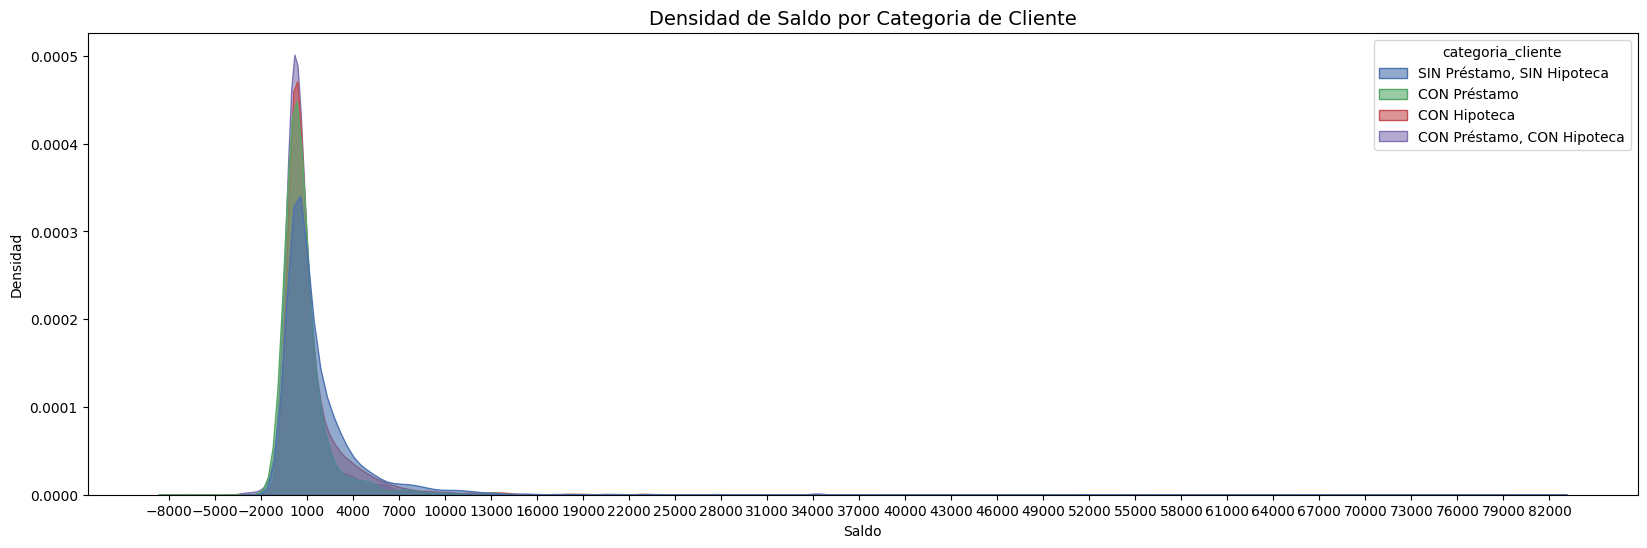

In [12]:
plt.figure(figsize=(20, 6))

sns.kdeplot(data=df_finanzas, x='balance', hue='categoria_cliente', fill=True, common_norm=False, alpha=0.6)

plt.title('Densidad de Saldo por Categoria de Cliente', fontsize=14)
plt.xlabel('Saldo')
plt.ylabel('Densidad')

plt.xticks(range(-8000,85000,3000))

plt.show()

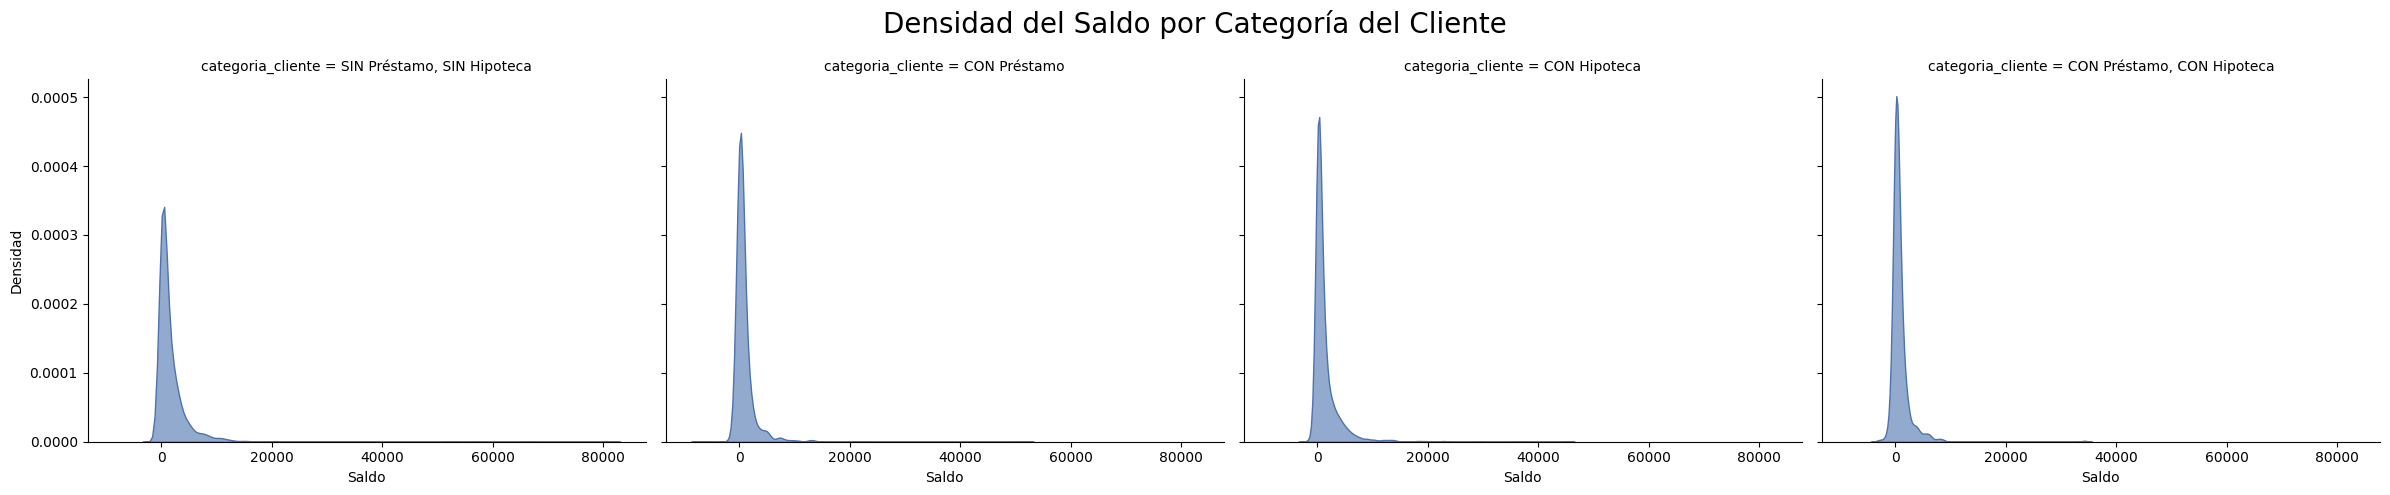

In [13]:
g = sns.FacetGrid(df_finanzas, col='categoria_cliente', col_wrap=4, height=5, aspect=1.2)

g.map(sns.kdeplot, 'balance', fill=True, common_norm=False, alpha=0.6)

g.figure.suptitle('Densidad del Saldo por Categoría del Cliente', fontsize=20)
g.set_axis_labels(x_var='Saldo', y_var='Densidad')
plt.tight_layout()
             
plt.show()

#### Saldo Promedio por Categoría

C:\Users\Natalya\AppData\Local\Temp\ipykernel_9528\2367805234.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  saldo_categoria = df_finanzas.groupby("categoria_cliente")['balance'].mean().reset_index(name="saldo_promedio")


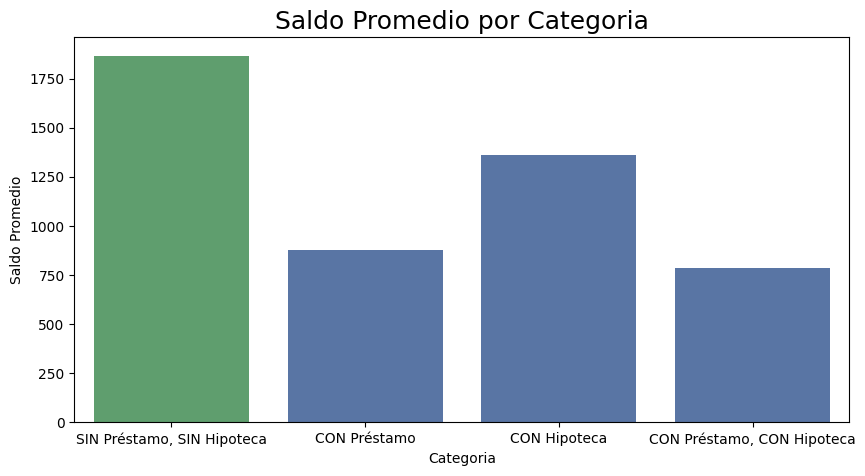

In [14]:
saldo_categoria = df_finanzas.groupby("categoria_cliente")['balance'].mean().reset_index(name="saldo_promedio")

plt.figure(figsize=(10,5))

sns.barplot(data=saldo_categoria,
              x="categoria_cliente",
              hue="categoria_cliente",
              legend=False,
              palette=colores,
              y="saldo_promedio")

plt.title('Saldo Promedio por Categoria', fontsize=18)
plt.xlabel('Categoria')
plt.ylabel('Saldo Promedio')

plt.show()

Tabla resumen del saldo promedio, mínimo y máximo para cada categoria de cliente

In [15]:
df_finanzas.groupby("categoria_cliente")[['balance']].agg(['count','mean','min','max','median']).reset_index()

C:\Users\Natalya\AppData\Local\Temp\ipykernel_9528\456170699.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_finanzas.groupby("categoria_cliente")[['balance']].agg(['count','mean','min','max','median']).reset_index()


categoria_cliente balance                                 
                                count         mean   min    max median
0  SIN Préstamo, SIN Hipoteca    7590  1868.089987 -1415  81204  695.0
1                CON Préstamo     929   877.978471 -6847  51439  280.0
2                CON Hipoteca    6427  1359.357554 -2049  45248  495.0
3  CON Préstamo, CON Hipoteca    1217   783.285127 -3058  34230  304.0

#### Incumplimiento por Categoría

In [16]:
incumplimiento_categoria = pd.merge(df_finanzas.query("default == 1").groupby(by="categoria_cliente").size().reset_index(name="default_si"),
                                    df_finanzas.query("default == 0").groupby(by="categoria_cliente").size().reset_index(name="default_no"),
                                    on="categoria_cliente")

incumplimiento_categoria['total'] = incumplimiento_categoria['default_no'] + incumplimiento_categoria['default_si']
incumplimiento_categoria["% incumplimiento"] = (incumplimiento_categoria['default_si'] / incumplimiento_categoria['total']) * 100

incumplimiento_categoria

C:\Users\Natalya\AppData\Local\Temp\ipykernel_9528\657191133.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incumplimiento_categoria = pd.merge(df_finanzas.query("default == 1").groupby(by="categoria_cliente").size().reset_index(name="default_si"),
C:\Users\Natalya\AppData\Local\Temp\ipykernel_9528\657191133.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_finanzas.query("default == 0").groupby(by="categoria_cliente").size().reset_index(name="default_no"),


,categoria_cliente,default_si,default_no,total,% incumplimiento
0,"SIN Préstamo, SIN Hipoteca",70,7520,7590,0.922266
1,CON Préstamo,49,880,929,5.274489
2,CON Hipoteca,88,6339,6427,1.369224
3,"CON Préstamo, CON Hipoteca",34,1183,1217,2.793755


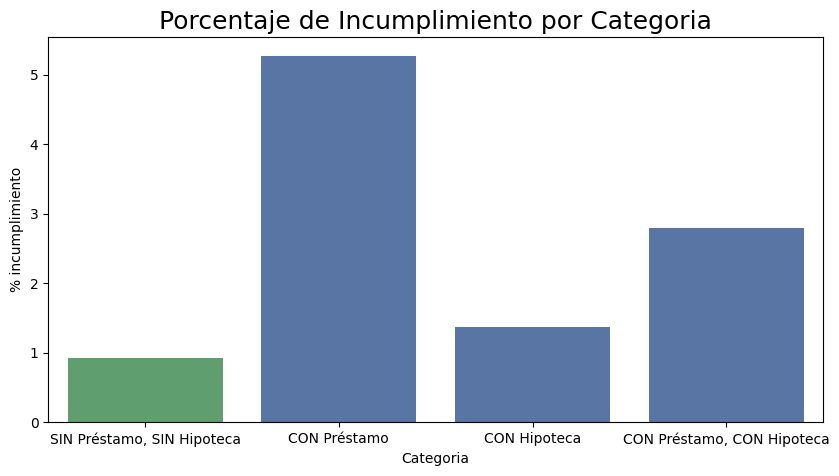

In [17]:
plt.figure(figsize=(10,5))

sns.barplot(data=incumplimiento_categoria,
              x="categoria_cliente",
              y="% incumplimiento",
              hue="categoria_cliente",
              legend=False,
              palette=colores)

plt.title('Porcentaje de Incumplimiento por Categoria', fontsize=18)
plt.xlabel('Categoria')
plt.ylabel('% incumplimiento')

plt.show()

#### Intensidad de los resultados por categoria

In [18]:
heatmap_categoria = pd.merge(saldo_categoria,
                            incumplimiento_categoria,
                            on="categoria_cliente")

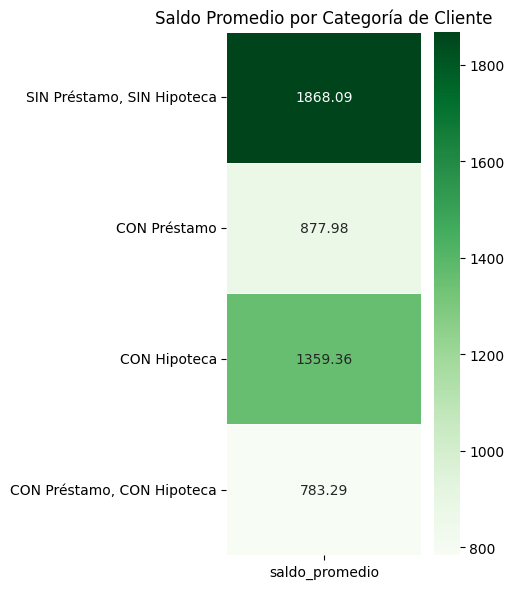

In [19]:
plt.figure(figsize=(5,6))

sns.heatmap(heatmap_categoria[['saldo_promedio']].set_index(heatmap_categoria['categoria_cliente']),
            annot=True, cmap="Greens", fmt=".2f", linewidths=.5)

plt.title('Saldo Promedio por Categoría de Cliente')
plt.ylabel('')

plt.tight_layout()
plt.show()

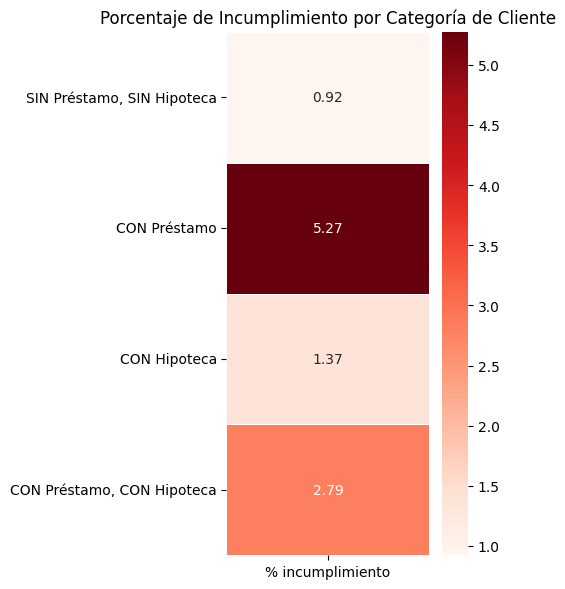

In [20]:
plt.figure(figsize=(5,6))

sns.heatmap(heatmap_categoria[['% incumplimiento']].set_index(heatmap_categoria['categoria_cliente']),
            annot=True, cmap="Reds", fmt=".2f", linewidths=.5)

plt.title('Porcentaje de Incumplimiento por Categoría de Cliente')
plt.ylabel('')

plt.tight_layout()
plt.show()